In [1]:
import numpy as np
import glob
from scipy.spatial import distance
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

/home/miguelmg/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(32, 32, 32)


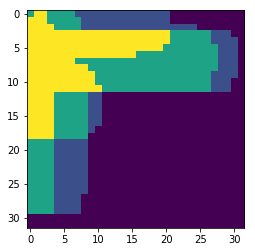

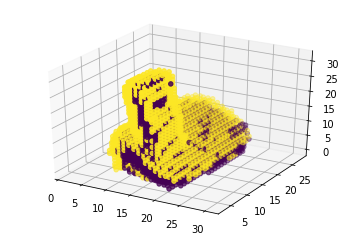

In [2]:
cloud_file = np.loadtxt('/home/miguelmg/Documents/CIDETEC/semestre 2/vision 3d/proyecto/6d pose/hinterstoisser/nubes/dataset/test_DNN/octree_pruned1040.txt')
##octree configuration parameters 
min_octrees_file = -0.0923735  #object capsule param from partialModelCofig file
max_octrees_file = -min_octrees_file
min_cubo = 0
max_cubo = 32

m = (max_cubo - min_cubo) / (max_octrees_file - min_octrees_file)
output_cube_size = 32*32*32

x = cloud_file[:,0]
y = cloud_file[:,1]
z = cloud_file[:,2]
v = cloud_file[:,3]
output_cube = np.zeros((32,32,32))
##### the cube of the octree of size 32x32x32 is obtained
for i in range(output_cube_size):
    x_cube = int((x[i]*m*2+32)/2)
    y_cube = int((y[i]*m*2+32)/2)
    z_cube = int((z[i]*m*2+32)/2)
    output_cube[x_cube][y_cube][z_cube] = v[i]
##### flatten representation of the cube is obtained
flatten_cube = output_cube.reshape(1,32*32*32)

#######################################################
######## Show 2D slide and 3D volume ##################
b = flatten_cube.reshape(32,32,32)
print (b.shape)
x_new = []
y_new = []
z_new = []
val = []
plt.imshow(b[28][:][:])
plt.show()
#mpld3.display()

for i in range(32):
    for j in range(32):
        for k in range(32):
            if b[i][j][k] >= 0.5 and b[i][j][k] < 0.6:
                x_new.append(i)
                y_new.append(j)
                z_new.append(k)
                val.append(0)
            elif b[i][j][k] >= 0.6:
                x_new.append(i)
                y_new.append(j)
                z_new.append(k)
                val.append(255)
                
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_new,y_new,z_new, c = val)
ax.set_xlim(left=0, right=32)
plt.show()    
######################################################

In [3]:
def voxnet(x, n_classes = 3 ):
    mu = 0
    sigma = 0.1
    #limpiar graficas anteriores
    #reset_graph()
    
    #Imagenes 
    img = tf.reshape(x, shape=[-1, 32,32,32,1])
    #tf.summary.image("Image", img)
    # Declarando las variables 
    weights = {'W_conv1':tf.Variable(tf.truncated_normal([5,5,5,1,32], mean = mu, stddev = sigma)),
               'W_conv2':tf.Variable(tf.truncated_normal([3,3,3,32,32], mean = mu, stddev = sigma)),
               'W_conv3':tf.Variable(tf.truncated_normal([3,3,3,12,8], mean = mu, stddev = sigma)),
               'W_fc1':tf.Variable(tf.truncated_normal([8*8*8*32,128], mean = mu, stddev = sigma)),
               'W_fc2':tf.Variable(tf.truncated_normal([1500, 500], mean = mu, stddev = sigma)),
               'W_fc3':tf.Variable(tf.truncated_normal([500, 100], mean = mu, stddev = sigma)),
               'W_fc4':tf.Variable(tf.truncated_normal([100,50], mean= mu, stddev= sigma)),
               'out':tf.Variable(tf.truncated_normal([128, n_classes], mean = mu, stddev = sigma))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
              'b_conv2':tf.Variable(tf.random_normal([32])),
              'b_conv3':tf.Variable(tf.random_normal([8])),
              'b_fc1':tf.Variable(tf.random_normal([128])),
              'b_fc2':tf.Variable(tf.random_normal([500])),
              'b_fc3':tf.Variable(tf.random_normal([100])),
              'b_fc4':tf.Variable(tf.random_normal([50])),
              'out':tf.Variable(tf.random_normal([n_classes]))}
   
    
    
    # Declarando la arquitectura
    
    #Input: 200x200x3     Output: 50x50x3
    l1 = tf.nn.conv3d(img, weights['W_conv1'], strides=[1,2,2,2,1], padding='SAME')
    l1 = tf.add(l1, biases['b_conv1'])
    l1 = tf.nn.relu(l1)
    print("l1: ",l1.shape)
    #l1 = tf.nn.dropout(l1, keep_rate)
    #l1 = tf.nn.max_pool3d(l1, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='VALID')
    
    #Input: 50x50x3     Output: 50x50x6
    l2 = tf.nn.conv3d(l1, weights['W_conv2'], strides=[1,1,1,1,1], padding='SAME')
    l2 = tf.add(l2, biases['b_conv2'])
    l2 = tf.nn.relu(l2)
    #l2 = tf.nn.dropout(l2, keep_rate)
    #print(l2)
    
    #Input: 50x50x6     Output: 25x25x6
    l2 = tf.nn.max_pool3d(l2, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='VALID')
    print("l2: ",l2.shape)
    
    #l3 = tf.nn.conv3d(l2, weights['W_conv3'], strides=[1,1,1,1,1], padding='SAME')
    #l3= tf.add(l3, biases['b_conv3'])
    #l3 = tf.nn.relu(l3)
    #l2 = tf.nn.dropout(l2, keep_rate2)
    #print(l2)
    
    #Input: 50x50x6     Output: 25x25x6
    #l3 = tf.nn.max_pool3d(l3, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='VALID')
    #print(l3.shape)
    
    
    #Input: 6x6x8     Output: 128
    fc1 = tf.reshape(l2, [-1, 8*8*8*32])
    fc1 = tf.nn.relu(tf.matmul(fc1, weights['W_fc1'])+biases['b_fc1'])
    fc1 = tf.nn.dropout(fc1, keep_rate)
                          
    #Input: 128     Output: 64
    #fc2 = tf.nn.relu(tf.matmul(fc1, weights['W_fc2'])+biases['b_fc2'])
    #fc2 = tf.nn.dropout(fc2, keep_rate)
    
    #fc3 = tf.nn.relu(tf.matmul(fc2, weights['W_fc3'])+biases['b_fc3'])
    #fc3 = tf.nn.dropout(fc3, keep_rate)
    
    #fc4 = tf.nn.relu(tf.matmul(fc3, weights['W_fc4'])+biases['b_fc4'])
    #fc4 = tf.nn.dropout(fc4, keep_rate)

    output_ = tf.matmul(fc1, weights['out'])+biases['out']

    # Declarando la funcion de costo y entrenamiento
    #cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y) )
    #optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    #almacenar costo
    #tf.summary.scalar("costo", cost)
    #generar logs
    #summaries = tf.summary.merge_all()
    
    return output_

In [4]:
# Declarando las entradas y salidas
x=tf.placeholder('float',[None,32*32*32])
y=tf.placeholder('float')
keep_rate = tf.placeholder(tf.float32)
output = voxnet(x)#################################

l1:  (?, 16, 16, 16, 32)
l2:  (?, 8, 8, 8, 32)


In [5]:
real_test_vol = flatten_cube
print(real_test_vol.shape)
x_in = real_test_vol
y_in = np.zeros((1,3))
print(y_in.shape)

(1, 32768)
(1, 3)


In [6]:
def test_neural_network():
    saver = tf.train.Saver()
    with tf.Session() as sess:
        model_path = '/home/miguelmg/Dropbox/tesis/pesos/regression/250.ckpt'
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, model_path)
        y_  = sess.run(output, feed_dict={x:x_in, y:y_in, keep_rate: 1})
        print("Predicted label", y_)

        return y_

In [7]:
points = test_neural_network()
points = points/100
print('Points: ',points)
best_distance = []
min_distance = 1000
pos_number = 0
pose_dir = sorted(glob.glob('/home/miguelmg/Documents/CIDETEC/semestre 2/vision 3d/proyecto/6d pose/hinterstoisser/nubes/modelo7/position/pose/*.dat'))
for file in pose_dir:
    pose = np.genfromtxt(file)
    number = re.search('_origin_(.+?).dat', file)
    distance_ = distance.euclidean(pose,points)
    if (distance_ < min_distance ):
        min_distance = distance_
        best_distance = pose
        pos_number = int(number.group(1))
        
print(best_distance, pos_number)


INFO:tensorflow:Restoring parameters from /home/miguelmg/Dropbox/tesis/pesos/regression/250.ckpt
Predicted label [[-38.667988    3.5885882   9.160513 ]]
Points:  [[-0.3866799   0.03588588  0.09160513]]
[-0.38475233  0.02463513  0.10657744] 1040


In [8]:
a_test = np.array([1,2,3])
b_test = np.array([4,5,6])
print(a_test - b_test)

[-3 -3 -3]
